In [191]:
import tensorflow as tf
from tensorflow import keras    
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os


import dataset store from Data_preparation

In [192]:
train_path = './dataset/train'
valid_path = './dataset/val'
test_path = './dataset/test'

In [193]:
breeds = [
    "Holstein_cow", "Jersey_cow", "Angus_cow", "Brahman_cow", "Hereford_cow",
    "Simmental_cow", "Limousin_cow", "Guernsey_cow", "Charolais_cow", "Ayrshire_cow"
]

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
                .flow_from_directory(directory=train_path, target_size=(224,224), classes=breeds, batch_size = 10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
                .flow_from_directory(directory=valid_path, target_size=(224,224), classes=breeds, batch_size = 10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
                .flow_from_directory(directory=test_path, target_size=(224,224), classes=breeds, batch_size = 10, shuffle=False)


Found 2414 images belonging to 10 classes.
Found 681 images belonging to 10 classes.
Found 685 images belonging to 10 classes.


if use "==" below the number must be same as number of image found above

In [194]:
assert train_batches.n >= 1000
assert valid_batches.n >= 300
assert test_batches.n >= 150
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 10
assert train_batches.batch_size == valid_batches.batch_size == test_batches.batch_size == 10
assert train_batches.class_indices == valid_batches.class_indices == test_batches.class_indices

# 1. Create a Neural Network

In [195]:
imgs , labels = next(train_batches)
print("Shape of the image batch: ", imgs.shape)
print("Shape of the label batch: ", labels.shape)

Shape of the image batch:  (10, 224, 224, 3)
Shape of the label batch:  (10, 10)


In [196]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize = (20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr,axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

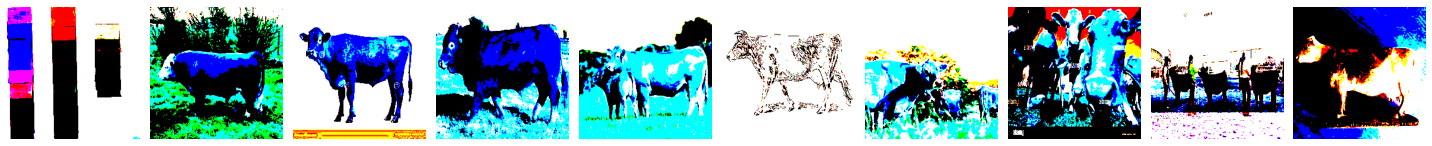

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [197]:
plotImages(imgs)
print(labels)

In [198]:
model = Sequential([
    Conv2D(filters=32,kernel_size=(3,3),activation='relu', padding='same',input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2,2),strides=2),
    Conv2D(filters=64, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    MaxPool2D(pool_size=(2,2), strides=2),
    Flatten(),
    Dense(units=10, activation='softmax'),
])

In [199]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 200704)            0         
_________________________________________________________________
dense_15 (Dense)             (None, 10)                2007050   
Total params: 2,026,442
Trainable params: 2,026,442
Non-trainable params: 0
___________________________________________

# 2. Training the model

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',metrics=['accuracy'])

In [201]:
history1 = model.fit(
    x=train_batches,
    validation_data=valid_batches,
    epochs=10,
    verbose=2,
)

Epoch 1/10
242/242 - 48s - loss: 30.1297 - accuracy: 0.3210 - val_loss: 2.3763 - val_accuracy: 0.5932
Epoch 2/10
242/242 - 47s - loss: 0.7610 - accuracy: 0.8277 - val_loss: 1.5466 - val_accuracy: 0.7357
Epoch 3/10
242/242 - 47s - loss: 0.2041 - accuracy: 0.9673 - val_loss: 1.3053 - val_accuracy: 0.7665
Epoch 4/10
242/242 - 47s - loss: 0.1226 - accuracy: 0.9888 - val_loss: 1.2310 - val_accuracy: 0.7827
Epoch 5/10
242/242 - 48s - loss: 0.1763 - accuracy: 0.9859 - val_loss: 1.1284 - val_accuracy: 0.7753
Epoch 6/10
242/242 - 48s - loss: 0.1167 - accuracy: 0.9909 - val_loss: 1.1259 - val_accuracy: 0.7783
Epoch 7/10
242/242 - 46s - loss: 0.1348 - accuracy: 0.9913 - val_loss: 1.1198 - val_accuracy: 0.7797
Epoch 8/10
242/242 - 47s - loss: 0.1124 - accuracy: 0.9917 - val_loss: 1.0129 - val_accuracy: 0.7695
Epoch 9/10
242/242 - 47s - loss: 0.1678 - accuracy: 0.9872 - val_loss: 0.9348 - val_accuracy: 0.7827
Epoch 10/10
242/242 - 48s - loss: 0.1134 - accuracy: 0.9921 - val_loss: 0.8992 - val_accur

# 3.Perform hyperparameter tuning (transfer learning)


In [211]:
from tensorflow.keras.applications import VGG16

# Load the VGG16 model
vgg16_model = tf.keras.applications.vgg16.VGG16()

In [212]:
#Using VGG16 as base model for transfer learning
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)
for layer in model.layers:
    layer.trainable = False
model.add(Dense(units=10, activation='softmax'))

In [213]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [214]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [215]:
history2 = model.fit(
    x=train_batches,
    steps_per_epoch = len(train_batches),
    validation_data = valid_batches, 
    validation_steps=len(valid_batches),
    epochs = 10, verbose =2
    )

Epoch 1/10
242/242 - 214s - loss: 1.9138 - accuracy: 0.3828 - val_loss: 1.2234 - val_accuracy: 0.6006
Epoch 2/10
242/242 - 220s - loss: 1.1029 - accuracy: 0.6338 - val_loss: 0.9849 - val_accuracy: 0.6872
Epoch 3/10
242/242 - 223s - loss: 0.8724 - accuracy: 0.7171 - val_loss: 0.8735 - val_accuracy: 0.7313
Epoch 4/10
242/242 - 227s - loss: 0.7335 - accuracy: 0.7746 - val_loss: 0.8118 - val_accuracy: 0.7592
Epoch 5/10
242/242 - 229s - loss: 0.6331 - accuracy: 0.8144 - val_loss: 0.7284 - val_accuracy: 0.7812
Epoch 6/10
242/242 - 225s - loss: 0.5546 - accuracy: 0.8335 - val_loss: 0.6879 - val_accuracy: 0.8062
Epoch 7/10
242/242 - 224s - loss: 0.4893 - accuracy: 0.8654 - val_loss: 0.6417 - val_accuracy: 0.8194
Epoch 8/10
242/242 - 223s - loss: 0.4357 - accuracy: 0.8757 - val_loss: 0.6136 - val_accuracy: 0.8253
Epoch 9/10
242/242 - 224s - loss: 0.3949 - accuracy: 0.8927 - val_loss: 0.5846 - val_accuracy: 0.8370
Epoch 10/10
242/242 - 223s - loss: 0.3538 - accuracy: 0.9114 - val_loss: 0.5699 - 

In [216]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)     

#Save Model

In [217]:
model.save('my_model.h5')  

#To Load Saved Model use:

   from tensorflow.keras.models import load_model
   
   model = load_model('my_model.h5')